# Calculating the threshold for splitting data

The code will automatically split a data time series up into periods that it considers as stationary. To do this some odds threshold must be set for saying whether to split the data or not. This script derives the threshold for splitting data based on empirical simulations of Gaussian noise.

In [20]:
%matplotlib inline
%load_ext Cython

from __future__ import print_function, division

import numpy as np
from math import lgamma
from scipy.interpolate import interp1d
import subprocess as sp
import os

import matplotlib as mpl
from matplotlib import pyplot as pl

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 16 }

mpl.rcParams.update(mplparams)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
%%cython

import numpy as np
cimport numpy as np

DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

cdef extern from "math.h":
    double log(double x)
    double exp(double x)
    int isinf(double x)

cpdef logplus(double x, double y):
    cdef double z = np.inf
    if isinf(x) and isinf(y) and (x < 0) and (y < 0):
        z = -np.inf
    elif (x > y) and not (isinf(x) and isinf(y)):
        z = x + log(1. + exp(y - x))
    elif (x <= y) and not (isinf(x) and isinf(y)):
        z = y + log(1. + exp(x - y))
    return z
    
cpdef find_change_st( int length, int minlength, np.ndarray[DTYPE_t, ndim=1] lfact ):
    # Looks to see if there are any change points in the times series based on
    # changes in the noise standard deviation. It computes the odds ratio of
    # the time series being compose of data with a single standard deviation,
    # compared to it being a times series with two distinct standard
    # deviations. The log odds ratio is returned as well as the index of the
    # change point.

    # get length of time series
    cdef int N = length

    cdef double lpi = log(np.pi);
    cdef double nlog2 = log(2.);

    cdef int changepoint = 2*minlength
    cdef double lodds = -np.inf
    cdef double logtot = -np.inf
    cdef double log_single = -np.inf
    
    # can't split the data if it's shorter than twice the minimum length
    if N < 2*minlength:
        return lodds, changepoint, logtot, log_single, -np.inf

    cdef np.ndarray ts = np.random.randn(N, 2) # generate random numbers
    ts2 = ts**2 # square array

    # compute the probability for the data being defined by a single standard deviation
    log_single = lfact[N-1] - nlog2 - N*lpi - N*(np.log(np.sum(ts[:,0]**2) + np.sum(ts[:,1]**2)))

    # for all possible change points in the data calculate the respective probabilities
    cdef np.ndarray log_double = np.zeros(N-2*minlength+1, dtype=DTYPE)
    logtot = -np.inf;
    
    sts1 = np.sum(ts2[0:minlength-1,0]) + np.sum(ts2[0:minlength-1,1])
    sts2 = np.sum(ts2[minlength-1:,0]) + np.sum(ts2[minlength-1:,1])
    
    # loop through all possible combinations of a single change point, only
    # allowing chunks of minlength or greater
    for i in range(minlength,N-minlength+1):
        ln1 = i
        ln2 = N-i
    
        idx = i-minlength;
    
        thists = ts2[i-1,0] + ts2[i-1,1]
        sts1 = sts1 + thists
        sts2 = sts2 - thists
    
        log1 = lfact[ln1-1] - nlog2 - ln1*lpi - ln1*(log(sts1))
        log2 = lfact[ln2-1] - nlog2 - ln2*lpi - ln2*(log(sts2))
    
        log_double[idx] = log1 + log2;

        # get total probability for any change point being good
        logtot = logplus(logtot, log_double[idx])

    # get odds ratio
    r = logtot - log_single;

    lodds = r
    changepoint = np.argmax(log_double)
    changepoint = changepoint + minlength - 1

    return lodds, changepoint, logtot, log_single, log_double

In [11]:
Ns = [30, 100, 200, 500, 1000, 2000, 5000, 10000]

# log factorial
lfact = np.zeros(max(Ns))
for i in range(1,max(Ns)):
    lfact[i] = lgamma(i+1)

Ntests = 30000
minchange = 5

# false alarm probabilities for splitting data 1%, 0.5% and 0.1%
faps = [0.01, 0.005, 0.001];

lofaps = np.zeros((len(Ns), len(faps)));

lodds = np.zeros(Ntests)

nbins = 1000

for i in range(len(Ns)):
    for j in range(Ntests):
        lodds[j], a, b, c, d = find_change_st(Ns[i], minchange, lfact)

    n, ob = np.histogram(lodds, bins=nbins);
    cn = np.cumsum(n, dtype=np.float)/Ntests
    ucn, icn = np.unique(cn, return_index=True)
    
    for j in range(len(faps)):
        f = interp1d(ucn, ob[icn], kind='cubic')
        lofaps[i,j] = f(1-faps[j])

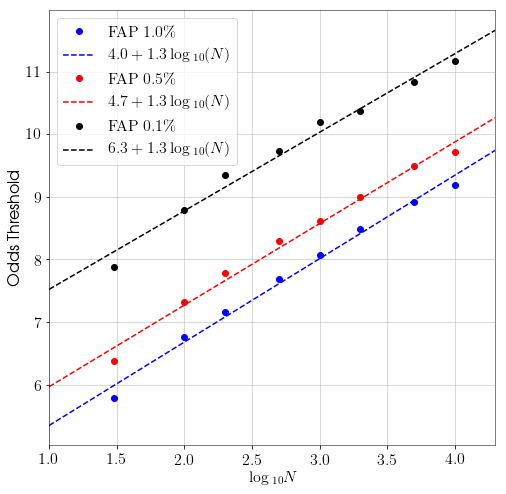

In [23]:
fig = pl.figure(figsize=(8,8))

ns = np.linspace(1., np.log10(20000.), 3)

colors = ['b', 'r', 'k']

for i, fap in enumerate(faps):
    pl.plot(np.log10(Ns), lofaps[:,i], label=r'${\rm FAP}~%.1f\%%$' % (100.*fap), marker='o', ls='none', color=colors[i])
    p = np.polyfit(np.log10(Ns), lofaps[:,i], deg=1)
    pl.plot(ns, p[1] + ns*p[0], ls='--', color=colors[i], label='$%.1f+%.1f\log{}_{10}(N)$' % (p[1], p[0]))

ax = pl.gca()
ax.set_xlim([ns[0], ns[-1]])
ax.set_xlabel('$\log{}_{10} N$')
ax.set_ylabel('Odds Threshold')
ax.grid(True)
ax.legend(loc='upper left')

if not os.path.isdir('../figures/changepoint'):
    os.makedirs('../figures/changepoint')

fig.savefig('../figures/changepoint/changepoint.png', dpi=300)
fig.savefig('../figures/changepoint/changepoint.pdf')
# convert to eps
p = sp.Popen('pdftops -eps ../figures/changepoint/changepoint.pdf ../figures/changepoint/changepoint.eps', stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# write out caption
fp = open('../figures/changepoint/caption.tex', 'w')
fp.write("""\label{fig:changepoint}
The odds threshold as a function of data length for three different false alarm probabilities calculated for
multiple realisations of simulated Gaussian noise. 
""")
fp.close()

In [13]:
p = np.polyfit(np.log10(Ns), lofaps[:,0], deg=1)

In [14]:
p

array([ 1.33187413,  4.01555472])